 # Clustering Notebook
 
 Salient Features:
 
 - Mosaic: Geomedian (recently added to dc_mosaic.py)
 - Clustering: K-Means and Birch (recently added to utils/dc_clustering.py)
 - Bands: User selects band(s) to cluster
 - Visualize and Export: Geomedian mosaic and cluster output to geotiff
 - Data: Landsat8 with pixel_qa
 

# Loading the data

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [1]:
import datacube
dc = datacube.Datacube(config='/home/localuser/.datacube.conf')

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.5-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


> **Listing available products**  
> Lookup product/platform name to load in your data.
<br>  

In [2]:
product_listing = dc.list_products()
product_listing[product_listing["name"].str.contains('samoa')]

,name,description,creation_time,product_type,label,time,format,lon,instrument,lat,platform,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,


> **Inspection Results**  
> Note the name and platform from the above table and initialize the product and platform respectively in the next block
<br>


# Inspect the metadata available for Vietnam in the Data Cube

In [3]:
from utils.data_cube_utilities.data_access_api import DataAccessApi

api = DataAccessApi(config='/home/localuser/.datacube.conf')

product = "ls7_ledaps_vietnam"
platform = "LANDSAT_7"

api.get_query_metadata(platform=platform, product=product, measurements=[])

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:184: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


{'lat_extents': (9.1762906272858, 13.964939912344285),
 'lon_extents': (102.4041694654867, 108.9310588253174),
 'time_extents': (datetime.datetime(1999, 9, 8, 3, 13, 19),
  datetime.datetime(2016, 12, 29, 3, 10)),
 'tile_count': 692,
 'pixel_count': 430347411}

# Area of Interest [Vietnam] 

In [4]:
# Picking a small area due to memory limitations
area_extent = {'latitude': (10.9, 11.00),'longitude': (107.8, 107.9)} 
# area_extent = {'latitude': (11.10, 11.39),'longitude': (106.8, 106.92)} 

# Visualize Area

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude  = area_extent['latitude'],
            longitude = area_extent['longitude'])

### Narrow down time range

In [6]:
from datetime import datetime 
date_range = (datetime(2010,1,1), datetime(2011,1,1))

### Load product

In [7]:
parameters = dict(measurements = [],#['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                  time = date_range,
                  platform = platform,
                  product =  product,
                  **area_extent)


dataset = dc.load(**parameters)

In [8]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-11T02:59:07 ... 2010-12-29T03:00:48
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 ... 10.9 10.9 10.9 10.9
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 ... 107.9 107.9 107.9
Data variables:
    *empty*
Attributes:
    crs:      EPSG:4326

## Create Geographic Chunks (For efficient processing)

In [9]:
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks

geographic_chunks = create_geographic_chunks(
                                latitude=area_extent['latitude'], 
                                longitude=area_extent['longitude'], 
                                geographic_chunk_size=.05)
geographic_chunks

[{'longitude': (107.8, 107.9), 'latitude': (10.9, 11.0)}]

## Create a GeoMedian Mosaic

In [10]:
import xarray as xr  
import numpy as np
import utils.data_cube_utilities.dc_mosaic as dc_mosaic
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
import importlib
importlib.reload(dc_mosaic)

measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.load(measurements = measurements,
                   time = date_range,
                   platform = platform,
                   product =  product,
                   longitude=chunk['longitude'],
                   latitude=chunk['latitude'])
    # Mask out clouds and scan lines.
    clean_mask = landsat_qa_clean_mask(data, platform)
    # Create the mosaic.
    product_chunks.append(dc_mosaic.create_hdmedians_multiple_band_mosaic(data, clean_mask=clean_mask, dtype=np.float32))

## Combine the chunks to produce the final mosaic

In [11]:
print(product_chunks)

[<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 ... 10.9 10.9 10.9 10.9
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 ... 107.9 107.9 107.9
Data variables:
    blue       (latitude, longitude) float64 227.6 231.3 218.2 ... 369.3 428.7
    green      (latitude, longitude) float64 365.4 395.1 357.5 ... 569.9 618.2
    red        (latitude, longitude) float64 281.8 291.0 251.1 ... 504.1 622.9
    nir        (latitude, longitude) float64 2.871e+03 2.956e+03 ... 2.785e+03
    swir1      (latitude, longitude) float64 1.372e+03 1.446e+03 ... 1.773e+03
    swir2      (latitude, longitude) float64 569.9 570.6 ... 701.3 1.023e+03
    pixel_qa   (latitude, longitude) float64 66.0 66.0 66.0 ... 66.0 66.0 66.0]


In [12]:
import utils.data_cube_utilities.dc_chunker as dc_chunker
import importlib
importlib.reload(dc_chunker)
final_mosaic = dc_chunker.combine_geographic_chunks(product_chunks)
final_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 ... 10.9 10.9 10.9 10.9
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 ... 107.9 107.9 107.9
Data variables:
    blue       (latitude, longitude) float64 227.6 231.3 218.2 ... 369.3 428.7
    green      (latitude, longitude) float64 365.4 395.1 357.5 ... 569.9 618.2
    red        (latitude, longitude) float64 281.8 291.0 251.1 ... 504.1 622.9
    nir        (latitude, longitude) float64 2.871e+03 2.956e+03 ... 2.785e+03
    swir1      (latitude, longitude) float64 1.372e+03 1.446e+03 ... 1.773e+03
    swir2      (latitude, longitude) float64 569.9 570.6 ... 701.3 1.023e+03
    pixel_qa   (latitude, longitude) float64 66.0 66.0 66.0 ... 66.0 66.0 66.0

## Export Mosaic Geotiff 

In [13]:
import utils.data_cube_utilities.dc_utilities as dc_utilities
# from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr
import importlib
importlib.reload(dc_utilities)
output_mosaic_file_name  =  "cluster_mosaic.tif"

dc_utilities.write_geotiff_from_xr(output_mosaic_file_name, final_mosaic, measurements, no_data=-9999)

## Take a look at the Mosaic

In [14]:
def figure_ratio(ds, fixed_width = 15):
    width = fixed_width
    height = len(ds.latitude) * (fixed_width / len(ds.longitude))
    return (width, height)

> ### Example of composited bands

> #### True color 

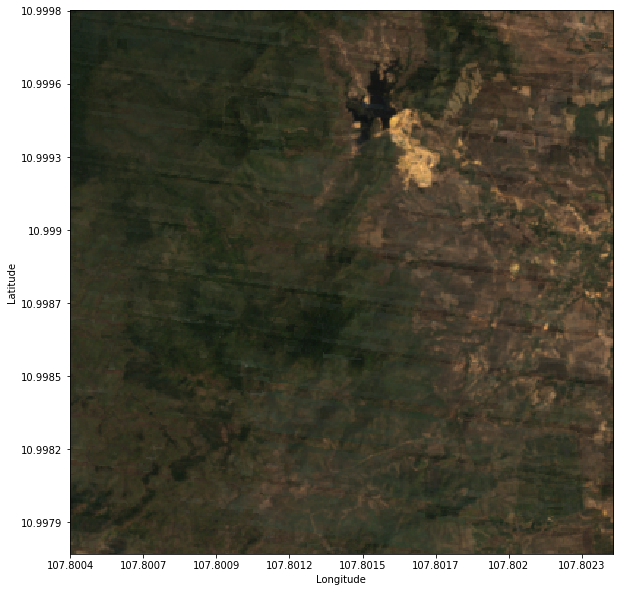

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from dc_notebook_utilities import rgb
rgb(final_mosaic,
    bands = ['red','green','blue'])

> ### False color 

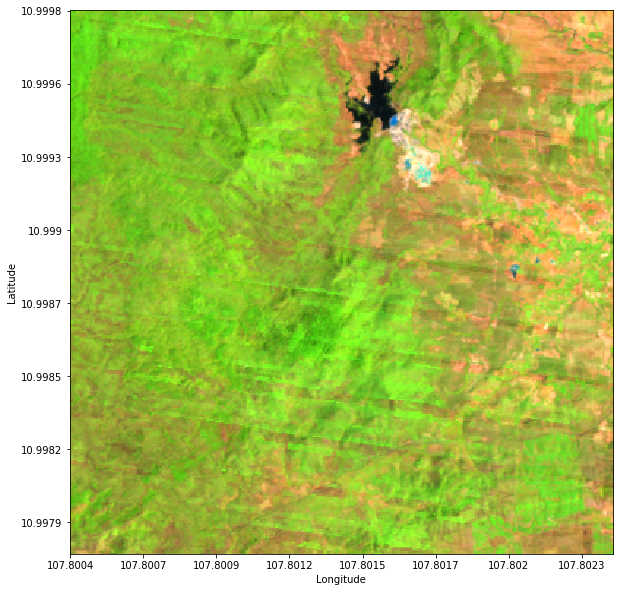

In [16]:
rgb(final_mosaic,
    bands = ['swir1','nir','red'])

> ### Example of a composited `swir1` band

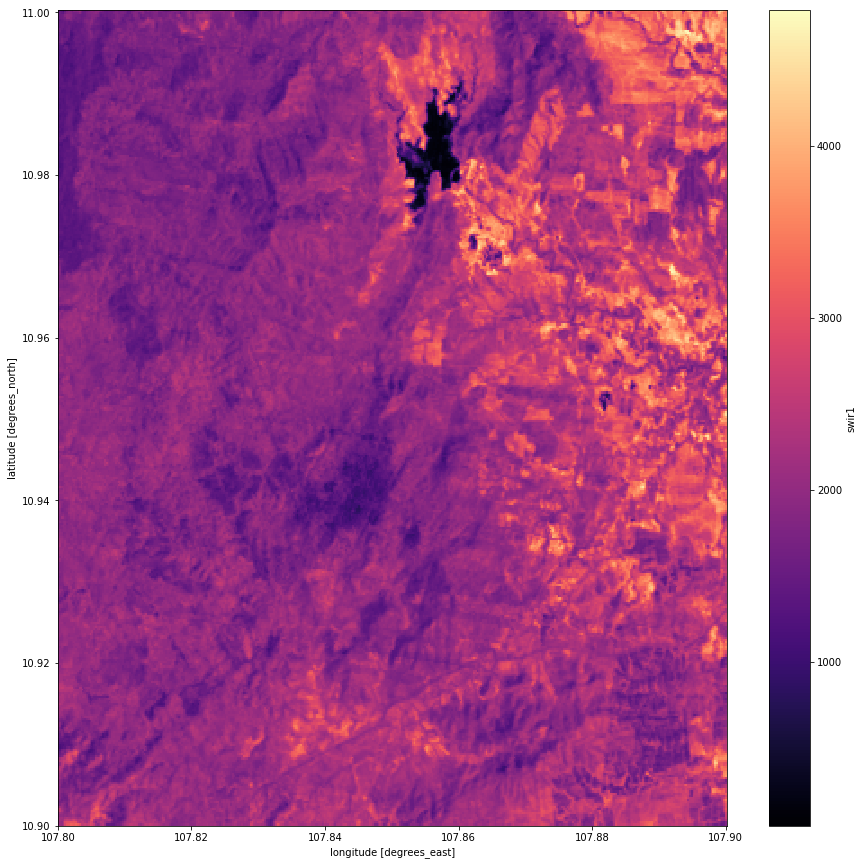

In [17]:
final_mosaic.swir1.plot(figsize = figure_ratio(final_mosaic), cmap = 'magma')

## Bands used for clustering

In [18]:
cluster_bands = ['red', 'green', 'blue', 'swir1']

# Perform K-Means Clustering

In [19]:
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset, get_frequency_counts

classification_4 =  kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=4)
freq_counts_4 =     get_frequency_counts(classification_4)
classification_8 =  kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=8)
freq_counts_8 =     get_frequency_counts(classification_8)
classification_12 = kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=12)
freq_counts_12 =    get_frequency_counts(classification_12)

## Visualize the clusters

There were 32739 data points in class 0, comprising 23.66% of all data points.
There were 30351 data points in class 1, comprising 21.93% of all data points.
There were 12745 data points in class 2, comprising 9.21% of all data points.
There were 62549 data points in class 3, comprising 45.20% of all data points.


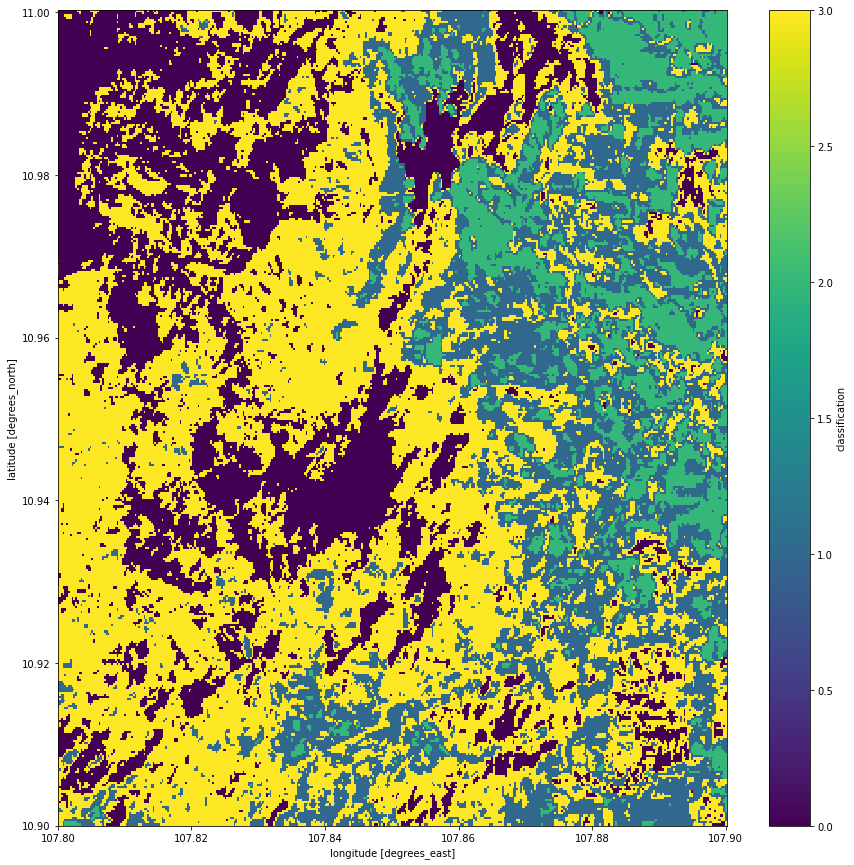

In [20]:
for class_num, freq, fractional_freq in freq_counts_4:
    print("There were {:d} data points in class {:d}, comprising {:.2%} "\
          "of all data points.".format(int(freq), int(class_num), 
                                       fractional_freq))
classification_4.classification.plot(figsize = figure_ratio(classification_4))
plt.show()

There were 1087 data points in class 0, comprising 0.79% of all data points.
There were 39307 data points in class 1, comprising 28.40% of all data points.
There were 15210 data points in class 2, comprising 10.99% of all data points.
There were 13643 data points in class 3, comprising 9.86% of all data points.
There were 23757 data points in class 4, comprising 17.17% of all data points.
There were 37355 data points in class 5, comprising 26.99% of all data points.
There were 7300 data points in class 6, comprising 5.28% of all data points.
There were 725 data points in class 7, comprising 0.52% of all data points.


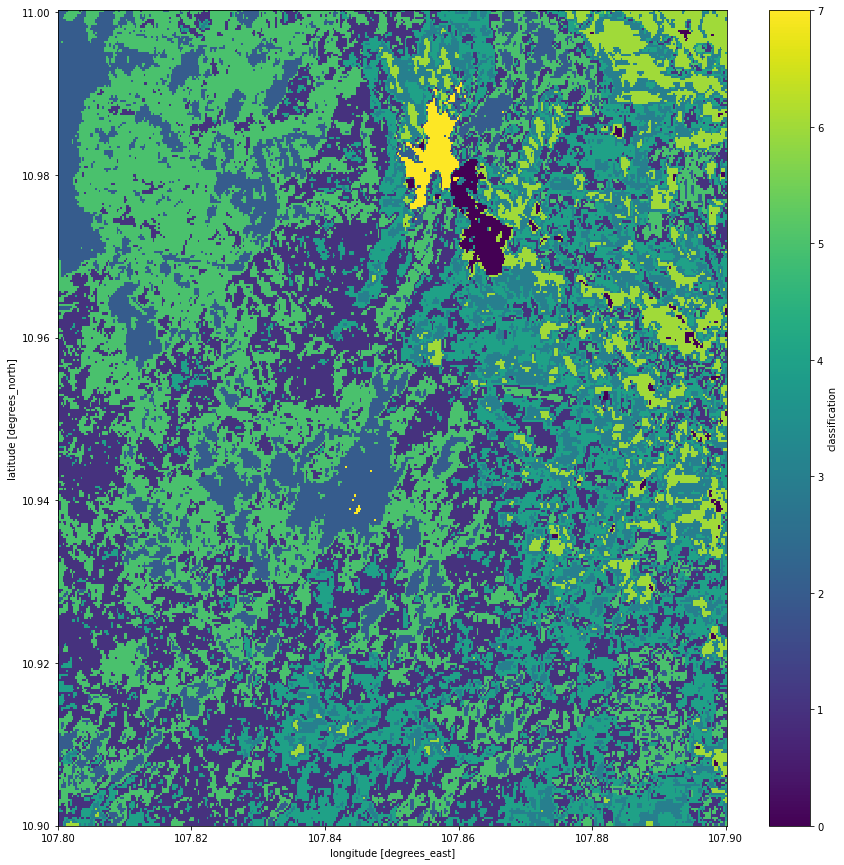

In [21]:
for class_num, freq, fractional_freq in freq_counts_8:
    print("There were {:d} data points in class {:d}, comprising {:.2%} "\
          "of all data points.".format(int(freq), int(class_num), 
                                       fractional_freq))
classification_8.classification.plot(figsize = figure_ratio(classification_8))
plt.show()

There were 2494 data points in class 0, comprising 1.80% of all data points.
There were 28441 data points in class 1, comprising 20.55% of all data points.
There were 13409 data points in class 2, comprising 9.69% of all data points.
There were 19735 data points in class 3, comprising 14.26% of all data points.
There were 259 data points in class 4, comprising 0.19% of all data points.
There were 20197 data points in class 5, comprising 14.59% of all data points.
There were 691 data points in class 6, comprising 0.50% of all data points.
There were 8849 data points in class 7, comprising 6.39% of all data points.
There were 6722 data points in class 8, comprising 4.86% of all data points.
There were 27842 data points in class 9, comprising 20.12% of all data points.
There were 703 data points in class 10, comprising 0.51% of all data points.
There were 9042 data points in class 11, comprising 6.53% of all data points.


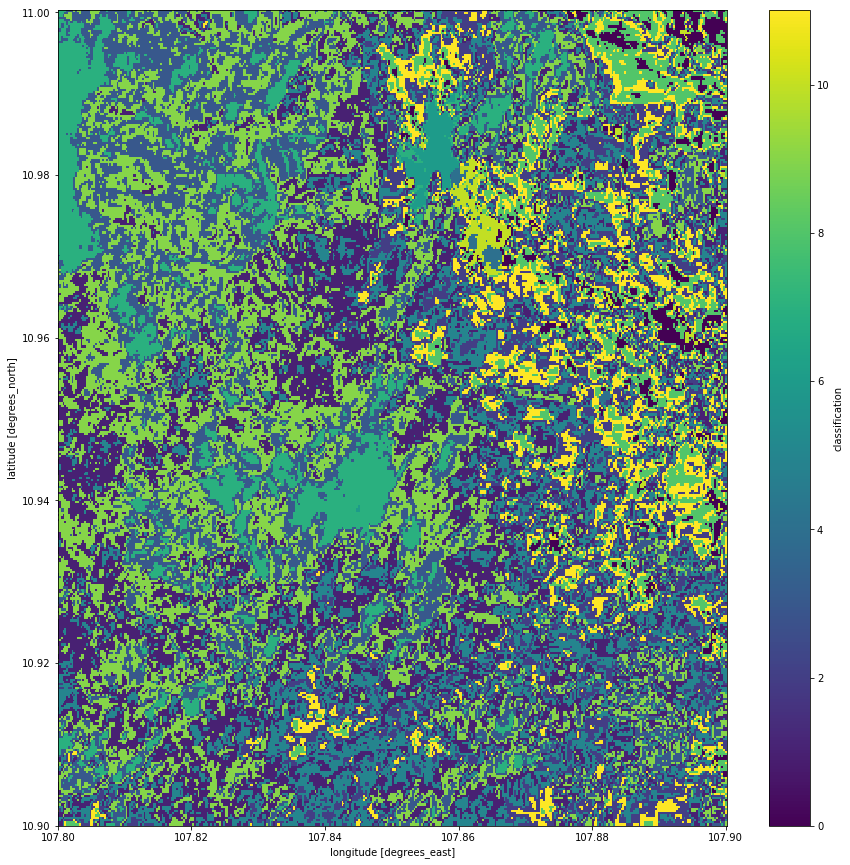

In [22]:
for class_num, freq, fractional_freq in freq_counts_12:
    print("There were {:d} data points in class {:d}, comprising {:.2%} "\
          "of all data points.".format(int(freq), int(class_num), 
                                       fractional_freq))
classification_12.classification.plot(figsize = figure_ratio(classification_12))
plt.show()

## Export the output (K-Means Clusters)

In [23]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

output_kmeans_cluster4_file_name  =  "cluster4_kmeans.tif"
output_kmeans_cluster8_file_name  =  "cluster8_kmeans.tif"
output_kmeans_cluster12_file_name  =  "cluster12_kmeans.tif"

write_geotiff_from_xr(output_kmeans_cluster4_file_name, classification_4, ['classification'], no_data=-9999)
write_geotiff_from_xr(output_kmeans_cluster8_file_name, classification_8, ['classification'], no_data=-9999)
write_geotiff_from_xr(output_kmeans_cluster12_file_name, classification_12, ['classification'], no_data=-9999)